In [1]:
import os
os.chdir(r'D:\ML\minor project')
print("Current working directory:", os.getcwd())

Current working directory: D:\ML\minor project


In [2]:
"""
Audio Deepfake Detection System - Spectrogram Image Version
"""

# %% Imports
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# %% Configuration
AUDIO_PATH = r"D:\ML\minor project\archive\KAGGLE\AUDIO"
SPECTROGRAM_PATH = r"D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
CLASS_NAMES = ['FAKE', 'REAL']

# Create new spectrogram directories
for label in CLASS_NAMES:
    os.makedirs(os.path.join(SPECTROGRAM_PATH, label), exist_ok=True)

# %% Spectrogram Generation Function
def create_spectrogram(audio_path, save_path):
    """Convert audio file to Mel-spectrogram and save as image"""
    y, sr = librosa.load(audio_path, sr=22050)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(2.24, 2.24), frameon=False)
    librosa.display.specshow(S_dB, sr=sr)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# %% Dataset Preparation (Run once)
def prepare_dataset():
    """Convert all audio files to spectrogram images"""
    for label in CLASS_NAMES:
        audio_dir = os.path.join(AUDIO_PATH, label)
        img_dir = os.path.join(SPECTROGRAM_PATH, label)  # Changed to new path

        for file_name in os.listdir(audio_dir):
            if file_name.endswith('.wav'):
                audio_path = os.path.join(audio_dir, file_name)
                img_name = f"{os.path.splitext(file_name)[0]}.png"
                img_path = os.path.join(img_dir, img_name)  # Save to new location
                create_spectrogram(audio_path, img_path)

if __name__ == "__main__":
    prepare_dataset()





C:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [8]:
# %% Enhanced Imports
import os
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                   Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import seaborn as sns
from PIL import Image

# %% Configuration
AUDIO_PATH = r"D:\ML\minor project\archive\KAGGLE\AUDIO"
SPECTROGRAM_PATH = r"D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced for smaller datasets
EPOCHS = 100
CLASS_NAMES = ['FAKE', 'REAL']

# %% Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8,1.2],
    fill_mode='constant',
    cval=0,
    horizontal_flip=True
)

# Validation datagen (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# %% Data Generators (Corrected)
train_generator = train_datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=CLASS_NAMES,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    SPECTROGRAM_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=CLASS_NAMES,
    shuffle=False
)

# %% Enhanced Class Weight Calculation
def calculate_class_weights():
    class_counts = {}
    for label in CLASS_NAMES:
        class_dir = os.path.join(SPECTROGRAM_PATH, label)
        class_counts[label] = len([f for f in os.listdir(class_dir) if f.endswith('.png')])

    y_train = []
    for label in CLASS_NAMES:
        y_train += [CLASS_NAMES.index(label)] * class_counts[label]

    weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    return {i: w for i, w in enumerate(weights)}

CLASS_WEIGHTS = calculate_class_weights()
print(f"Class weights: {CLASS_WEIGHTS}")

# %% Simplified CNN Model
def create_cnn_model():
    model = Sequential([
        Conv2D(8, (3,3), activation='relu', padding='same', input_shape=(*IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(16, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    return model

# %% Training Configuration
early_stop = EarlyStopping(
    monitor='val_recall',  # Focus on minority class recall
    patience=20,
    min_delta=0.001,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# %% Enhanced Evaluation Function
def evaluate_model():
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        SPECTROGRAM_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False,
        classes=CLASS_NAMES
    )

    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # ROC Curve
    if len(np.unique(y_true)) > 1:  # Only plot if both classes present
        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        roc_auc = roc_auc_score(y_true, y_pred_probs)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve.png')
        plt.close()

    return model.evaluate(test_generator)

# %% Main Execution
if __name__ == "__main__":
    # Dataset verification
    print("Class distribution:")
    class_counts = {}
    for label in CLASS_NAMES:
        path = os.path.join(SPECTROGRAM_PATH, label)
        count = len([f for f in os.listdir(path) if f.endswith('.png')])
        class_counts[label] = count
        print(f"{label}: {count} samples")

    # Handle extreme imbalance
    if abs(class_counts['FAKE'] - class_counts['REAL']) > 10:
        print("\nWarning: Severe class imbalance detected!")
        print("Consider data augmentation for minority class or collecting more samples")

    # Model initialization
    model = create_cnn_model()

    # Calculate steps
    steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE)
    val_steps = max(1, val_generator.samples // BATCH_SIZE)

    # Training
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=val_steps,
        epochs=EPOCHS,
        callbacks=[early_stop, checkpoint],
        class_weight=CLASS_WEIGHTS
    )

    # Final evaluation
    model = tf.keras.models.load_model('best_model.keras')
    evaluate_model()


Found 52 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Class weights: {0: 0.5714285714285714, 1: 4.0}
Class distribution:
FAKE: 56 samples
REAL: 8 samples

Consider data augmentation for minority class or collecting more samples


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.6068 - loss: 1.4684 - precision: 0.2330 - recall: 0.6500 - val_accuracy: 0.9167 - val_loss: 0.5955 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9375 - loss: 0.8720 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.5995 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7500 - loss: 0.2178 - precision: 0.0000e+00 - recall: 0.0000e+00

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.8431 - loss: 0.4799 - precision: 0.2917 - recall: 0.2500 - val_accuracy: 0.9167 - val_loss: 0.6107 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7500 - loss: 2.2624 - precision: 0.3333 - recall: 0.3333 - val_accuracy: 0.9167 - val_loss: 0.6224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.7917 - loss: 1.3544 - precision: 0.3622 - recall: 0.6250 - val_accuracy: 0.9167 - val_loss: 0.6604 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7500 - loss: 1.5412 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.6704 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.7717 - loss: 0.5652 - precision: 0.2125 - recall: 0.5417 - val_accuracy: 

Found 52 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.2292 - loss: 4.3269 - precision_1: 0.1408 - recall_1: 0.9524

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,precision_1,recall_1,val_accuracy,val_loss,val_precision_1,val_recall_1
  current = self.get_monitor_value(logs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2344 - loss: 4.2163 - precision_1: 0.1422 - recall_1: 0.9286 - val_accuracy: 0.1667 - val_loss: 0.9433 - val_precision_1: 0.0909 - val_recall_1: 1.0000
Epoch 2/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0000e+00 - loss: 3.4770 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.0000e+00 - loss: 3.4770 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.0833 - val_loss: 0.9036 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5907 - loss: 1.9393 - precision_1: 0.1508 - recall_1: 0.2333

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step - accuracy: 0.6236 - loss: 1.9046 - precision_1: 0.1488 - recall_1: 0.2250 - val_accuracy: 0.8333 - val_loss: 0.4914 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8750 - loss: 1.1568 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - accuracy: 0.8750 - loss: 1.1568 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.3717 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step - accuracy: 0.8618 - loss: 1.0673 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.2711 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8750 - loss: 0.8100 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.3022 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step - accuracy: 0.8594 - loss: 0.6100 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.3972 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7500 - loss: 0.5862

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.87      0.96      0.92        56
        REAL       0.00      0.00      0.00         8

    accuracy                           0.84        64
   macro avg       0.44      0.48      0.46        64
weighted avg       0.76      0.84      0.80        64



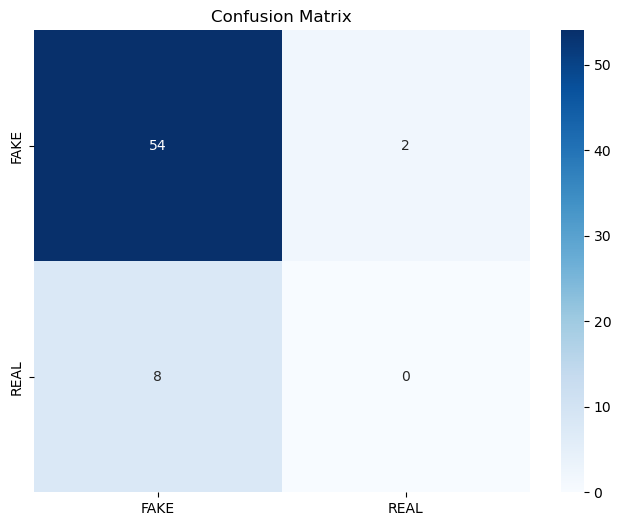

In [9]:
"""
Audio Deepfake Detection using Transfer Learning
"""

# %% Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# %% Configuration
SPECTROGRAM_PATH = r"D:\ML\minor project\archive\KAGGLE\SPECTROGRAMS"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
CLASS_NAMES = ['FAKE', 'REAL']

# %% Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# %% Data Generators
def create_generator(datagen, subset):
    return datagen.flow_from_directory(
        SPECTROGRAM_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset=subset,
        classes=CLASS_NAMES,
        color_mode='rgb'  # Pretrained models need 3 channels
    )

train_generator = create_generator(train_datagen, 'training')
val_generator = create_generator(train_datagen, 'validation')

# %% Class Weight Calculation
class_counts = train_generator.classes.sum(), len(train_generator.classes) - train_generator.classes.sum()
total = sum(class_counts)
CLASS_WEIGHTS = {0: total/(2*class_counts[0]), 1: total/(2*class_counts[1])}

# %% Model Setup
def create_transfer_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Freeze base layers
    base_model.trainable = False

    # Add custom head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

model = create_transfer_model()

# %% Model Compilation
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# %% Callbacks
callbacks = [
    EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# %% Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS
)

# %% Evaluation
def evaluate_model():
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        SPECTROGRAM_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False,
        classes=CLASS_NAMES
    )

    # Load best model
    model = tf.keras.models.load_model('best_model.h5')

    # Generate predictions
    y_true = test_generator.classes
    y_pred = (model.predict(test_generator) > 0.5).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

evaluate_model()

# %% Prediction Function
def predict_spectrogram(img_path):
    img = tf.keras.preprocessing.image.load_img(
        img_path,
        target_size=IMG_SIZE,
        color_mode='rgb'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)[0][0]
    return "FAKE" if prediction > 0.5 else "REAL"
